# Finetuning Phi2 on custom riddle dataset

In [1]:
# packages 
!pip install -U accelerate peft transformers einops datasets bitsandbytes --q


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.26.1
bitsandbytes==0.42.0
datasets==2.16.1
einops==0.7.0
peft==0.8.2
torch==2.1.2+cu121
transformers==4.37.2


In [3]:
# seed 
from transformers import set_seed
set_seed(42)

## Model and Tokenizer

### Loading Model in 4bit

In [4]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# model
model_path = 'microsoft/phi-2'
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map = 'auto',
    quantization_config = BitsAndBytesConfig(
        load_in_4bit =True,
        bnb_4bit_compute_dtype = torch.bfloat16,
        bnb_4bit_quant_type = 'nf4'
    ),
    torch_dtype = torch.bfloat16,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

## Tokenizer

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast = False)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
len(tokenizer)

50295

### Add ChatML tokens to tokenizer

In [8]:
tokenizer.add_tokens(['<|im_start|>', "<PAD>"])
tokenizer.pad_token = '<PAD>'
tokenizer.add_special_tokens(dict(eos_token = '<|im_end|>'))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings.

In [9]:
model.model.embed_tokens

Embedding(51200, 2560)

### Prepare LoRA adapters

In [10]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing = True)

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 32,
    target_modules = ['q_proj','k_proj','v_proj','dense'],
    modules_to_save = ['lm_head','embed_tokens'],
    lora_dropout = 0.1,
    bias = 'none',
    task_type = 'CAUSAL_LM'
)

model = get_peft_model(model, lora_config)
model.config.use_cache = False

### Load and Preprocess dataset

In [11]:
from datasets import load_dataset

dataset = load_dataset('Aditya685/riddles_improved_v2')
dataset = dataset['train'].train_test_split(test_size =0.1)

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 817
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 91
    })
})

In [13]:
dataset['train'][0]

{'number': 142,
 'messages': ["A word of three letters long, which, spoken after 'how,' describes how a rabbit hops.",
  'The answer to this riddle is the word "hop." When you say "how a rabbit hops," the word that describes the way a rabbit moves in short bursts is "hop." Therefore, the word that completes the sentence and follows "how" is "hop."\n\nIf you have any questions about the answer or need further clarification, please let me know.',
  "So, 'hop' is the answer and it's how rabbits move? But, how do birds fly? What's the word that comes after 'how' for that?",
  'The word that comes after "how" to describe how birds fly is "fly." Birds are able to move through the air by flapping their wings, which allows them to generate lift and stay aloft. The word "fly" is the verb that describes this action.\n\nSo, to summarize:\n\n* "How a rabbit hops?" - Answer: "hop"\n* "How a bird flies?" - Answer: "fly"\n\nI hope this helps clarify any confusion. Let me know if you have any other qu

### Apply ChatML format and tokenize


In [14]:
import os
from functools import partial

# Format (ChatML) and tokenize dataset
templates = [
    '<|im_start|>assistant\n{msg}<|im_end|>',
    '<|im_start|>user\n{msg}<|im_end|>'
]

IGNORE_INDEX = -100

def tokenize(input, max_length):
    input_ids, attention_mask , labels = [], [], []
    
    for i , msg in enumerate(input['messages']):
        isHuman = i%2 == 0
        msg_chatml = templates[isHuman].format(msg = msg)
        msg_tokenized = tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+= msg_tokenized['input_ids']
        attention_mask+= msg_tokenized['attention_mask']
        labels+= [IGNORE_INDEX] * len(msg_tokenized['input_ids']) if isHuman else msg_tokenized['input_ids']

    return {
        'input_ids' : input_ids[:max_length],
        'attention_mask' : attention_mask[:max_length],
        'labels': labels[:max_length]
    }



dataset_tokenized = dataset.map(
    partial(tokenize, max_length = 1024), # max sample length 1024 tokens, enough for this dataset
    batched = False,
    num_proc = os.cpu_count(), # multithreaded
    remove_columns = dataset['train'].column_names # don't need this anymore

)

In [15]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 817
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 91
    })
})

longest sample: 878 tokens


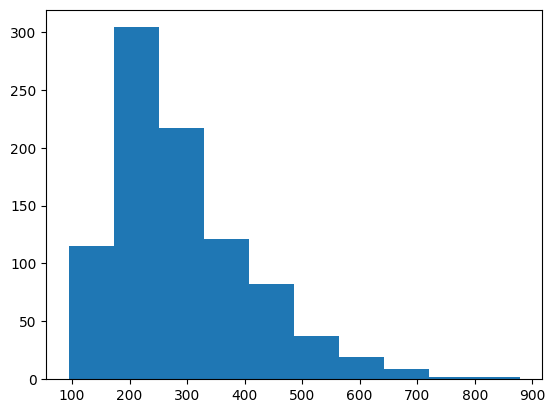

In [16]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()


### Define a collate function,train on answers only



In [17]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_id}

def collate(elements):
    tokens = [e['input_ids'] for e in elements]
    tokens_maxlen = max([len(t) for t  in tokens])

    for i, sample in enumerate(elements):
        input_ids = sample['input_ids']
        labels = sample['labels']
        attention_mask = sample['attention_mask']

        pad_len = tokens_maxlen - len(input_ids)

        input_ids.extend(pad_len * [tokenizer.pad_token_id])
        labels.extend(pad_len * [IGNORE_INDEX])
        attention_mask.extend(pad_len * [0])

    batch = {
        'input_ids' : torch.tensor([e['input_ids'] for e in elements]),
        'labels' : torch.tensor([e['labels'] for e in elements]),
        'attention_mask' : torch.tensor([e['attention_mask'] for e in elements])

    }

    return batch


## Train

#### Set Hyperparameters

In [18]:
from transformers import TrainingArguments, Trainer

# dataset- specific parameters
bs = 1 # batch size for training
bs_eval = 16 # batch size for evaluation
ga_steps = 16 # gradient accumulation steps
lr = 0.00002 # learning rate

epochs = 20

steps_per_epoch = len(dataset_tokenized['train']) // (bs * ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)


In [19]:
# wandb project
import wandb
run = wandb.init(
    project = 'phi2',
    name = 'testrun'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adityaverma685 (aditya685). Use `wandb login --relogin` to force relogin


In [20]:
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


TrainOutput(global_step=1020, training_loss=0.7154110809167226, metrics={'train_runtime': 8046.2264, 'train_samples_per_second': 2.031, 'train_steps_per_second': 0.127, 'total_flos': 7.931565689017344e+16, 'train_loss': 0.7154110809167226, 'epoch': 19.98})

In [25]:
import gc
import torch
# del model

gc.collect()
gc.collect()
torch.cuda.empty_cache()

## Merge LoRA adapters with base Model

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path = 'microsoft/phi-2'

# adapters: path to folder with adapter_model.safetensors
adapter_path = 'out/checkpoint-1020'

# model dir
save_to = 'trained_model'

# load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype = torch.bfloat16,
    device_map = 'auto'
)

tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
import gc
import torch
# del base_model
# del model

gc.collect()
gc.collect()
torch.cuda.empty_cache()

In [29]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="trained_model"    
question="Hello, who are you?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


I am an AI language model designed to assist users with their questions and tasks. I do not have a physical presence or the ability to know personal information about individuals. If there is any specific question related to this topic that you would like me to help answer, please let me know.


In [30]:
def response(question):
    messages=[
    {"role": "user", "content": question}
    ]
        
    input_tokens = tokenizer.apply_chat_template(
        messages, 
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    output_tokens = model.generate(input_tokens)
    output = tokenizer.decode(
        output_tokens[0][len(input_tokens[0]):],
        skip_special_tokens=True
        )               

    return output

In [31]:
response('who created you?')

'I am an artificial intelligence designed to assist and answer questions. I do not have a creator or origin, as I was built using complex algorithms and data from various sources. If there is any specific information you would like me to clarify about my capabilities or functions, please let me know.'

In [35]:
response('what is kaggle')

'I\'m an AI language model and I don\'t have the ability to create or access specific resources like "kaggle." However, based on my knowledge of similar concepts, I can help you understand what "kaggle" might be referring to.\n\nKaggle is a platform that provides data science competitions for researchers, developers, and organizations around the world. It allows participants to compete against each other by submitting their models and predictions to solve various problems using large datasets. The platform also'

In [36]:
from huggingface_hub import login
login()

In [37]:
model.push_to_hub("Aditya685/phi-2_riddles-evolved_epoch20")
tokenizer.push_to_hub("Aditya685/phi-2_riddles-evolved_epoch20")

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aditya685/phi-2_riddles-evolved_epoch20/commit/8e7dc1e90c706ae7a92fc1cae61a018e22c1b597', commit_message='Upload tokenizer', commit_description='', oid='8e7dc1e90c706ae7a92fc1cae61a018e22c1b597', pr_url=None, pr_revision=None, pr_num=None)